In [1]:
from pathlib import Path
import random
import os
import re

import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from simple_dataloader import create_dataloader

In [2]:
def set_seed(seed):
    """
    Sets the random seed for reproducibility.
    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    print("CUDA is available. Using GPU")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU


## Data

In [4]:
data_path = Path('data/ben_bucket')
pcaps = data_path.glob('**/*.pcap')
pcap_paths = pd.Series(pcaps)

In [5]:
def extract_pcap_info(path):
    p = Path(path)
    parts = p.parts
    location = parts[3]  # 4th part (traffic/location/date...)
    date_str = parts[4]  # 5th part is the date
    app = parts[5]       # 6th part is the app
    vpn_type = parts[6]   # 7th part is VPN/Non-VPN

    date = pd.to_datetime(date_str, format='%Y%m%d_%H%M%S')
    
    return location, date, app, vpn_type

# Apply the function to each path in the series
df = pd.DataFrame(pcap_paths.apply(extract_pcap_info).tolist(), columns=['location', 'date', 'app', 'vpn_type'])
df['pcap_path'] = pcap_paths

In [6]:
# randomly sample
df_huji = df[df.location == 'HujiPC']
df_huji = df_huji.sample(frac=1).reset_index(drop=True).head(2000)

# train-val split
df_huji.sort_values(by='date')
split_index = int(len(df_huji) * 0.7)

# Split the data into train and test based on the temporal order
df_huji_train = df_huji[:split_index]
df_huji_val = df_huji[split_index:]

train_pcap_paths = df_huji_train.pcap_path.astype(str)
train_labels = df_huji_train.app

val_pcap_paths = df_huji_val.pcap_path.astype(str)
val_labels = df_huji_val.app

In [7]:
label_types = np.unique(train_labels)

In [8]:
# Create the dataloader
train_loader = create_dataloader(train_pcap_paths, train_labels, batch_size=8, shuffle=True, min_flow_length=100)
val_loader = create_dataloader(val_pcap_paths, val_labels, batch_size=8, shuffle=True, min_flow_length=100)

100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


## Model

- [X] split
- [ ] train
- [ ] train other domain
- [ ] cross peprformance

In [35]:
class ConfigurableCNN(nn.Module):
    def __init__(self, params):
        super(ConfigurableCNN, self).__init__()
        self.params = params
        
        # Create convolutional layers
        layers = []
        in_channels = params['in_channels']
        
        for conv_layer in params['conv_layers']:
            layers.append(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=conv_layer['out_channels'],
                          kernel_size=conv_layer['kernel_size'],
                          stride=conv_layer['stride'],
                          padding=conv_layer['padding'])
            )
            layers.append(nn.ReLU())
            in_channels = conv_layer['out_channels']
        
        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(kernel_size=params['pool_kernel_size'], stride=params['pool_stride'])

        # Calculate flattened size after convolutions and pooling
        flattened_size = self._get_flattened_size(params['image_size'])

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, params['fc1_out_features'])
        self.fc2 = nn.Linear(params['fc1_out_features'], params['num_classes'])
        self.dropout = nn.Dropout(params['dropout_prob'])

    def _get_flattened_size(self, input_size):
        # Simulate passing a tensor through the network to calculate the size after conv layers
        x = torch.randn(1, 1, input_size, input_size)  # Assuming single channel input for now
        x = self.conv_layers(x)
        x = self.pool(x)
        return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [36]:
# Example parameters
params = {
    'num_classes': len(label_types),   # Number of classes for classification
    'image_size': 1500,  # Input image size is 1500x1500
    'conv_layers': [
        {'out_channels': 4, 'kernel_size': 5, 'stride': 2, 'padding': 2 },
        {'out_channels': 8, 'kernel_size': 5, 'stride': 2, 'padding': 2 },
        {'out_channels': 16, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1 },
    ],
    'in_channels': 1,
    'pool_kernel_size': 4,
    'pool_stride': 4,
    'fc1_out_features': 128,      # Number of neurons in the first fully connected layer
    'dropout_prob': 0.4           # Dropout probability
}

In [37]:
# Model initialization
model = ConfigurableCNN(params)
model = model.to(device)

In [38]:
model(flowpics)

tensor([[-0.0462,  0.0750, -0.0274,  0.0609],
        [-0.0403,  0.0786, -0.0070,  0.0510],
        [-0.0459,  0.0730, -0.0128,  0.0629],
        [-0.0455,  0.0778, -0.0198,  0.0598],
        [-0.0550,  0.0743, -0.0189,  0.0633],
        [-0.0514,  0.0818, -0.0245,  0.0595],
        [-0.0361,  0.0926, -0.0219,  0.0614],
        [-0.0445,  0.0708, -0.0217,  0.0693]], device='cuda:1',
       grad_fn=<AddmmBackward0>)

In [39]:
# Optimizer and loss function
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
num_epochs = 1

In [34]:
train_batch_losses = []
train_batch_accuracies = []
val_batch_losses = []
val_batch_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0
    
    # Training loop with progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False) as pbar:
        for i, (flowpics, labels) in enumerate(pbar):
            # Move inputs and labels to the device (GPU or CPU)
            flowpics = flowpics.unsqueeze(1)  # add a channels dimension
            flowpics, labels = flowpics.to(device), labels.to(device).long()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(flowpics)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_train_loss += loss.item() * flowpics.size(0)
            total_train_samples += flowpics.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()

            # Store batch-level training metrics
            batch_loss = loss.item()
            batch_accuracy = correct_train_predictions / total_train_samples * 100
            train_batch_losses.append(batch_loss)
            train_batch_accuracies.append(batch_accuracy)

    # Validation loop with progress bar
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False) as pbar:
            for i, (flowpics, labels) in enumerate(pbar):
                # Move inputs and labels to the device (GPU or CPU)
                flowpics = flowpics.unsqueeze(1)  # add a channels dimension
                flowpics, labels = flowpics.to(device), labels.to(device).long()

                # Forward pass
                outputs = model(flowpics)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item() * flowpics.size(0)
                total_val_samples += flowpics.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()

                # Store batch-level validation metrics
                batch_val_loss = loss.item()
                batch_val_accuracy = correct_val_predictions / total_val_samples * 100
                val_batch_losses.append(batch_val_loss)
                val_batch_accuracies.append(batch_val_accuracy)

    # Print statistics for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Last Training Batch - Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%")
    print(f"  Last Validation Batch - Loss: {batch_val_loss:.4f}, Accuracy: {batch_val_accuracy:.2f}%")

Epoch 1/1 (Train):  18%|█▊        | 50/277 [00:04<00:22, 10.23it/s]

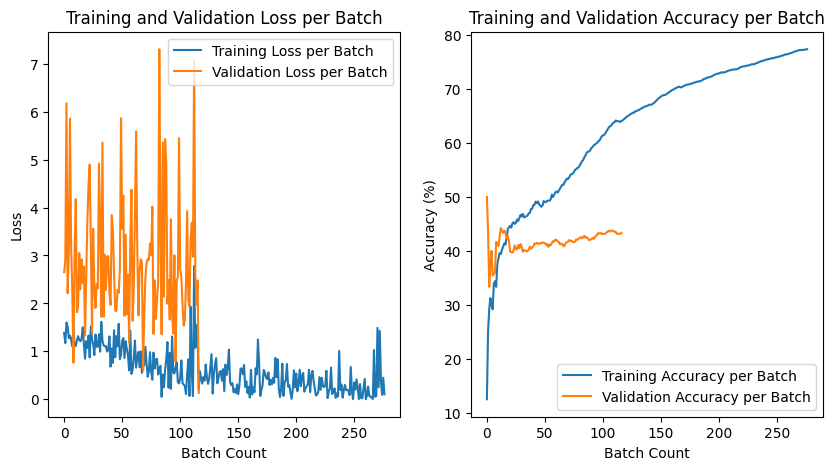

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_batch_losses, label='Training Loss per Batch')
plt.plot(val_batch_losses, label='Validation Loss per Batch')
plt.xlabel('Batch Count')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Batch')
plt.legend()

# Plotting batch-level training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_batch_accuracies, label='Training Accuracy per Batch')
plt.plot(val_batch_accuracies, label='Validation Accuracy per Batch')
plt.xlabel('Batch Count')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy per Batch')
plt.legend()

plt.show()

tensor([276., 102.], device='cuda:1')

In [25]:
for flowpics, labels in train_loader:
    print(flowpics.sum((1, 2)))

tensor([149., 140., 100., 156., 163., 438., 281., 406.])
tensor([234., 215., 328., 154., 152., 105., 258., 429.])
tensor([133., 350., 102., 113., 420., 609., 233., 144.])
tensor([121., 305., 401., 304., 114., 269., 130., 109.])
tensor([210., 108., 106., 121., 548., 136., 105., 299.])
tensor([186., 287., 105., 229., 136., 222., 302., 111.])
tensor([342., 287., 138.,  49., 202., 152., 101., 251.])
tensor([338., 317., 127., 248., 264., 117., 291., 551.])
tensor([143., 126., 112., 149., 133., 152., 312., 132.])
tensor([249., 237., 146., 131., 108., 165., 695., 231.])
tensor([266., 182., 118., 178., 125., 235., 358., 225.])
tensor([248., 312., 194., 114., 111., 165., 481., 118.])
tensor([410., 114., 196., 189., 102., 102., 124., 117.])
tensor([498., 150., 155., 300., 291., 317., 396., 737.])
tensor([292., 156., 523., 141., 221., 109., 161., 124.])
tensor([230., 461., 415., 123., 111., 112., 519., 107.])
tensor([220., 227., 320., 184., 223., 121., 358., 111.])
tensor([122., 359., 100., 129.,